In [1]:
# In this example we will train 2 BDTs to differentiate between a CP-even and a CP-odd Higgs for the rhorho channel
# One BDT will use only 1 variable analogous to current methodology, the second BDT will include additional information
# to help improve the seperation 

This is the Jupyter Notebook I will use for the Master's project, it is based on Example 1 also available in the same directory.

In [2]:
!pip install --user uproot
import sys
sys.path.append("/eos/home-m/acraplet/.local/lib/python2.7/site-packages")

In [3]:
import uproot 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt


In [4]:
# loading the tree
tree = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]
tree2 = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_VBFHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]


#These are new trees, added by Danny on 13/10
tree3=uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_tt.root")["ntuple"]  
#note, instead of the first t we can have e,m, different decay modes

In [5]:
# define what variables are to be read into the dataframe

variables = [  "wt_cp_sm", "wt_cp_ps", "wt_cp_mm",
                "rand",
                "pt_1","pt_2",
                "met",
                "aco_angle_1", "aco_angle_5", "aco_angle_7", "aco_angle_6",
                "y_1_1", "y_1_2",
                "ip_sig_1", "ip_sig_2",
                "mva_dm_1","mva_dm_2",
                "tau_decay_mode_1","tau_decay_mode_2",
                "deepTauVsJets_medium_1","deepTauVsJets_medium_2",
                "deepTauVsEle_vvloose_1","deepTauVsEle_vvloose_2",
                "deepTauVsMu_vloose_1","deepTauVsMu_vloose_2",
                "trg_doubletau",
             ]

df = tree.pandas.df(variables)

df2 = tree2.pandas.df(variables)

#tree3 should be more comprehensive and complete as it includes all decay types and more
#info for tau->a1 decays. Again we save the same variables for now

#df3 = tree3.pandas.df(variables)

#combine VBF and ggH events

df = pd.concat([df,df2], ignore_index=True)



We will keep working on the first tree for now (because everything is set up for it but in the future it'll be useful to look at the other ones)

In [6]:
# apply some preselections, these selections are used to mimic those used 
#in the analysis and to select only rhorho events
# also use random number "rand" and tau spinner weights "wt_cp_{sm,ps,mm}" 
#to select a sample of CP-even and CP-odd
# like events. the weights go beween 0 and 2 so by dividing by 2 
#we can interpret these as probabilities and select
# CP-even(odd) events if the rand is less than this probability 


import random
random.seed(123456)

df_1 = df[
      (df["tau_decay_mode_1"] == 1) 
    & (df["tau_decay_mode_2"] == 1) 
    & (df["mva_dm_1"] == 1) 
    & (df["mva_dm_2"] == 1)
    # comment some selections to help with stats
    #& (df["deepTauVsJets_medium_1"] > 0.5) 
    #& (df["deepTauVsEle_vvloose_1"] > 0.5)
    #& (df["deepTauVsMu_vloose_1"] > 0.5)
    #& (df["deepTauVsJets_medium_2"] > 0.5) 
    #& (df["deepTauVsEle_vvloose_2"] > 0.5)
    #& (df["deepTauVsMu_vloose_2"] > 0.5)
    #& (df["trg_doubletau"] > 0.5)
]

df_ps = df_1[
      (df_1["rand"]<df_1["wt_cp_ps"]/2)     #a data frame only including the pseudoscalars
]

df_sm = df_1[
      (df_1["rand"]<df_1["wt_cp_sm"]/2)     #data frame only including the scalars
]




In [7]:
# create target labels (y)
         
# prepare the target labels
y_sm = pd.DataFrame(np.ones(df_sm.shape[0]))
y_ps = pd.DataFrame(np.zeros(df_ps.shape[0]))

y = pd.concat([y_sm, y_ps])  #is this just about having the right shape ?
y.columns = ["class"]

# prepare the dataframe to use in training
X = pd.concat([df_sm, df_ps])

# drop any other variables that aren't required in training

X2 = X.drop([
            "wt_cp_sm","wt_cp_ps","wt_cp_mm", "rand",
            "tau_decay_mode_1","tau_decay_mode_2","mva_dm_1","mva_dm_2",
            "deepTauVsJets_medium_1","deepTauVsJets_medium_2",
            "deepTauVsEle_vvloose_1","deepTauVsEle_vvloose_2",
            "deepTauVsMu_vloose_1","deepTauVsMu_vloose_2",
            "trg_doubletau",
           ], axis=1).reset_index(drop=True) 

# now we create a seperate version of X where we drop all variables except for aco_angle_1 
# which is the most sensitive simple variable

X1 = X2.drop(X2.columns.difference(["aco_angle_1"]), axis=1).reset_index(drop=True) 


#how do we print the dimensions of a panda object ? I would like to see if we indeed only
#have 'aco_angle_1' on the X1 variable.

In [8]:
# define function to plot 'signal' vs 'background' for a specified variables
# useful to check whether a variable gives some separation between
# signal and background states
def plot_signal_background(data1, data2, column,
                        bins=100, x_uplim=0, **kwargs):

    if "alpha" not in kwargs:  #just setting the transparency of columns
        kwargs["alpha"] = 0.5

    df1 = data1[column]
    df2 = data2[column]

    fig, ax = plt.subplots()
    df1 = df1.sample(3000, random_state=1234)   #we only take 3000 points
    df2 = df2.sample(3000, random_state=1234)
    low = max(min(df1.min(), df2.min()),-5)     
    high = max(df1.max(), df2.max())
    
    if x_uplim != 0: high = x_uplim #you can choose where you plot from

    ax.hist(df1, bins=bins, range=(low,high), **kwargs,label='Data1')
    ax.hist(df2, bins=bins, range=(low,high), **kwargs,label='Data2')
    
    if x_uplim != 0:
        ax.set_xlim(0,x_uplim)
        
    plt.title('Difference between data 1 and data 2 for variable %s'%column,weight='bold')
    plt.xlabel('%s'%key)
    plt.ylabel('Occurences out of 3000')
    plt.grid()
    plt.legend()

    # ax.set_yscale('log')


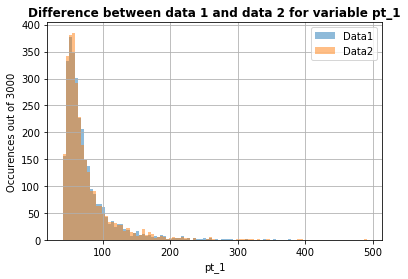

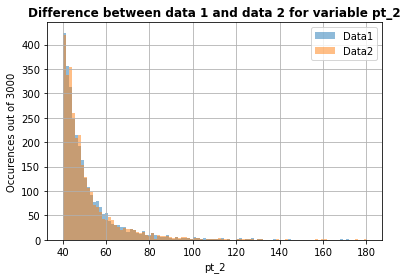

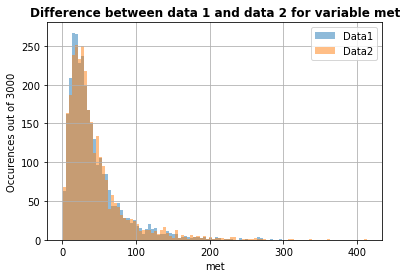

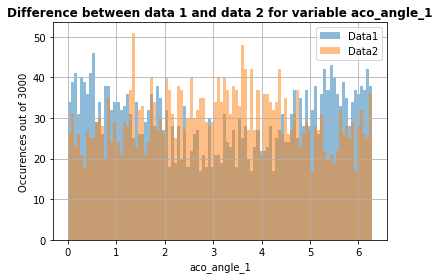

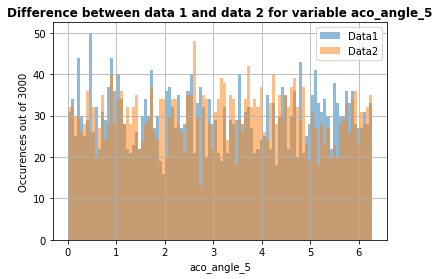

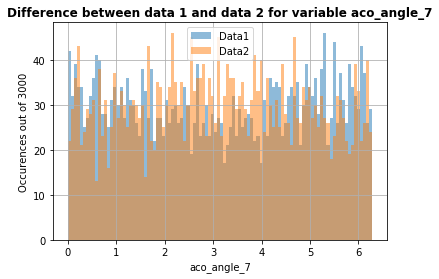

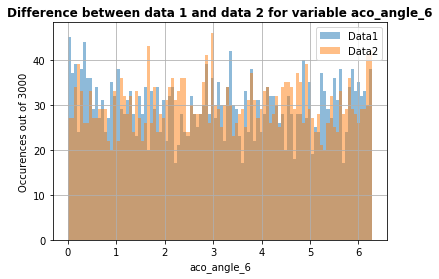

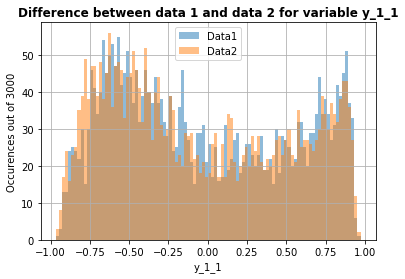

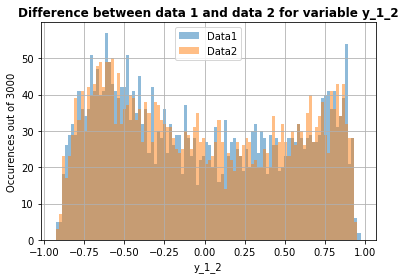

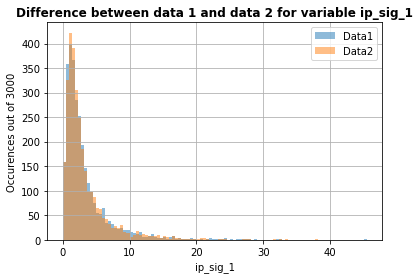

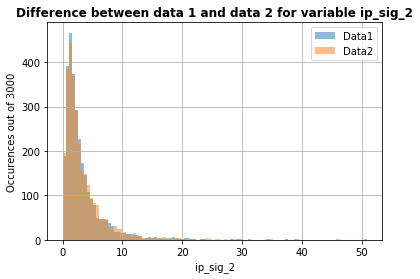

In [9]:
# make plots of all variables

for key, values in X2.iteritems():
    #print(key)
    plot_signal_background(df_ps, df_sm, key, bins=100)

plt.savefig('Ps_SM_sig_bck_%s.png'%key) #put in the loop to have everything

## Task 1: Calculate the acoplanary angles

Before any traning, let's try and reconstruct aco_angle_1 from the low level variable. 
$\mathbf{\lambda}^{\pm}=(0,\mathbf{j}^\pm)$ where $\mathbf{j}^\pm$ is the impact parameter vector defined as the vector btw the primary vertex (PV) and the point of closest approach (PCA).

Then we need to boost $\mathbf{\lambda}^{\pm}$ into the zero momentum frame (ZMF) thus giving $\mathbf{\lambda}^{*\pm}$. I will need to code a function to boost any four vector into the pion's ZMF. 

We will also need $\mathbf{q}^{*\pm}$ are the four-vector for charged pions, boosted in the ZMF. 

After that we will calculate $\mathbf{\lambda}^{*\pm}_{\perp}$ the transverse component of $\mathbf{\lambda}^{*\pm}$ w.r.t. $\mathbf{q}^{*\pm}$. 

Finally, the acoplanary angle $\phi_{CP}$ is definied by 

$\phi_{\mathrm{CP}}=\left\{\begin{array}{ll} \phi^{*} &  \text { if } O^{*} \geq 0 \\  360^{\circ}-\phi^{*} & \text { if } O^{*}<0 \end{array}\right\}$

$\phi^{*}=\arccos \left(\hat{\lambda}_{\perp}^{*+} \cdot \hat{\lambda}_{\perp}^{*-}\right)$

with $O^{*}=\hat{q}^{*-} \cdot\left(\hat{\lambda}_{\perp}^{*+} \times \hat{\lambda}_{\perp}^{*-}\right)$.


Start with $\mathbf{j}^\pm$, check what we have in terms of available informations.

In [10]:
# The impact parameter vector for the leading and sub-leading are given by ip_{x,y,z}_{1,2}

#ip_sig_{1,2} gives the significance of the impact paramter, will be usefull in future.

#Now define a new panda dataframe, which I'll only use to get out the acoplanary angle
#using low level variables (maybe we'll need to reconstruct the impact parameter vector 
#as well but I don't think that this is usefull just yet).

variables4 = ["ip_x_1","ip_y_1","ip_z_1",
              "ip_x_2","ip_y_2","ip_z_2",
              "aco_angle_1", 
              "pi_E_1","pi_px_1","pi_py_1","pi_pz_1",
              "pi_E_2","pi_px_2","pi_py_2","pi_pz_2",
              "tau_decay_mode_1","tau_decay_mode_2",
              "mva_dm_1","mva_dm_2",
              "pi0_E_1","pi0_px_1","pi0_py_1","pi0_pz_1",
              "pi0_E_2","pi0_px_2","pi0_py_2","pi0_pz_2",
              "y_1_1","y_1_2"
              
             ]


df4 = tree.pandas.df(variables4)

df4 = df4[
      (df4["tau_decay_mode_1"] == 1) 
    & (df4["tau_decay_mode_2"] == 1) 
    & (df4["mva_dm_1"] == 1) 
    & (df4["mva_dm_2"] == 1)
]

#keep that ??    

#note: maybe we'll have to apply some cuts, to not get the a1 for example whose 
# decays are more complicated


In [11]:
#Let's try and use the pylorentz module for performing boosts
# more info: https://gitlab.sauerburger.com/frank/pylorentz/-/blob/master/pylorentz/__init__.py

!pip install --user pylorentz

from pylorentz import Momentum4
from pylorentz import Vector4
from pylorentz import Position4

In [28]:
#Some geometrical functions

def cross_product(vector3_1,vector3_2):
    if len(vector3_1)!=3 or len(vector3_1)!=3:
        print('These are not 3D arrays !')
    x_perp_vector=vector3_1[1]*vector3_2[2]-vector3_1[2]*vector3_2[1]
    y_perp_vector=vector3_1[2]*vector3_2[0]-vector3_1[0]*vector3_2[2]
    z_perp_vector=vector3_1[0]*vector3_2[1]-vector3_1[1]*vector3_2[0]
    return np.array([x_perp_vector,y_perp_vector,z_perp_vector])

def dot_product(vector1,vector2):
    if len(vector1)!=len(vector2):
        raise Arrays_of_different_size
    prod=0
    for i in range(len(vector1)):
        prod=prod+vector1[i]*vector2[i]
    return prod


def norm(vector):
    if len(vector)!=3:
        print('This is only for a 3d vector')
    return np.sqrt(vector[0]**2+vector[1]**2+vector[2]**2)

In [80]:
#HERE DEFINE ALL USEFULL 4VECTORS

#Need convert the 4 Vector into a 4 momenta ?
pi_1_4Mom=Momentum4(df4["pi_E_1"],df4["pi_px_1"],df4["pi_py_1"],df4["pi_pz_1"])
pi_2_4Mom=Momentum4(df4["pi_E_2"],df4["pi_px_2"],df4["pi_py_2"],df4["pi_pz_2"])

#Same for the pi0
pi0_1_4Mom=Momentum4(df4["pi0_E_1"],df4["pi0_px_1"],df4["pi0_py_1"],df4["pi0_pz_1"])
pi0_2_4Mom=Momentum4(df4["pi0_E_2"],df4["pi0_px_2"],df4["pi0_py_2"],df4["pi0_pz_2"])


In [84]:
#HERE PERFORM THE LORENTZ BOOSTS

#This is the COM frame of the two charged pions w.r.t. which we'll boost
ref_COM_4Mom=Momentum4(pi_1_4Mom+pi_2_4Mom)

#Lorentz boost everything in the ZMF of the two charged pions
pi0_1_4Mom_star=pi0_1_4Mom.boost_particle(-ref_COM_4Mom)
pi0_2_4Mom_star=pi0_2_4Mom.boost_particle(-ref_COM_4Mom)


pi_1_4Mom_star=pi_1_4Mom.boost_particle(-ref_COM_4Mom)
pi_2_4Mom_star=pi_2_4Mom.boost_particle(-ref_COM_4Mom)

#momenta of the two pions are indeed opposite in this frame !
print(pi_1_4Mom_star[1],pi_2_4Mom_star[1])

[ 5.50583093  5.2545177  -2.18931145 ...  8.93803642  7.52830656
 -2.90606245] [-5.50583093 -5.2545177   2.18931145 ... -8.93803642 -7.52830656
  2.90606245]


[[-5.05602056e-03  9.37763993e-04 -1.71730221e-03 ... -4.18970264e-03
  -5.16750410e-04  8.62079438e-04]
 [ 3.95047361e-03 -4.68481458e-04  9.95485912e-05 ... -1.30944215e-03
   1.03552801e-03 -1.77732351e-03]
 [-4.42780343e-03  2.79917828e-03  6.69624996e-04 ...  1.51207568e-03
   4.88251039e-04 -1.93212580e-03]] [[-0.64855415  0.31373566 -0.93032132 ... -0.90242895 -0.4113991
   0.31198803]
 [ 0.50674162 -0.15673383  0.05392888 ... -0.28204353  0.82441211
  -0.64321643]
 [-0.56797046  0.93648515  0.36275876 ...  0.32568919  0.38870998
  -0.69923965]]


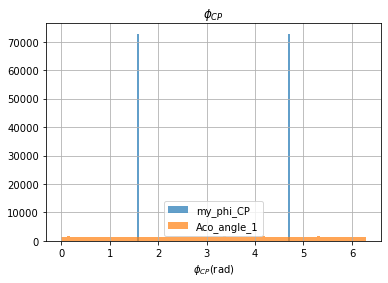

In [96]:
#HERE STEPS TO GET TO PHI_CP

#calculating the angle from the perpendicular components of lambda
pi0_1_3Mom_star_perp=cross_product(pi0_1_4Mom_star[1:],pi_1_4Mom_star[1:])  #should we take the other order ?
pi0_2_3Mom_star_perp=cross_product(pi0_2_4Mom_star[1:],pi_2_4Mom_star[1:])

#Have I forgotten to normalise it ?? looks like yes, yes it was...
pi0_1_3Mom_star_perp=pi0_1_3Mom_star_perp/np.linalg.norm(pi0_1_3Mom_star_perp, ord=2, axis=1, keepdims=True)
pi0_1_3Mom_star_perp2=pi0_1_3Mom_star_perp/norm(pi0_1_3Mom_star_perp)

print(pi0_1_3Mom_star_perp,pi0_1_3Mom_star_perp2)

pi0_2_3Mom_star_perp=pi0_2_3Mom_star_perp/np.linalg.norm(pi0_2_3Mom_star_perp, ord=2, axis=1, keepdims=True)

#Calculating phi_star
phi_star=np.arccos(dot_product(pi0_1_3Mom_star_perp,pi0_2_3Mom_star_perp))

#assume 1 is + and 2 is -, have checked that the other gives same 
bigO_star=dot_product(pi_2_4Vect_star[1:]/norm(pi_2_4Vect_star[1:]),cross_product(pi0_1_3Mom_star_perp,pi0_2_3Mom_star_perp))

#additionnal shift that needs to be done do see differences between odd and even scenarios, with y=Energy ratios
phi_CP=np.where((df4["y_1_1"]*df4["y_1_2"]>0),2*np.pi-phi_CP,phi_CP)

#perform the shift w.r.t. O* sign
phi_CP=np.where((bigO_star<0),2*np.pi-phi_star,phi_star)

#now plot distribution
plt.figure()
plt.hist(phi_CP,bins=100, alpha=0.7,label='my_phi_CP')
plt.hist(df4['aco_angle_1'],bins=100, alpha=0.7,label='Aco_angle_1')
plt.title('$\phi_{CP}$')
plt.grid()
plt.xlabel('$\phi_{CP}$(rad)')
plt.legend()
#plt.savefig('phi_cp_hist.png')




In [91]:
#print the first few results vs given angles
print("index \t mycalc \t aco_angle_1 \t y_T")
for i in range(100):
    print("{} \t {:.4f} \t {:.4f} \t {:.4}".format(i, phi_CP[i],np.array(df4['aco_angle_1'])[i], phi_CP[i]-np.array(df4['aco_angle_1'])[i]))

index 	 mycalc 	 aco_angle_1 	 y_T
0 	 0.3553 	 5.9279 	 -5.573
1 	 1.2678 	 5.0154 	 -3.748
2 	 0.1221 	 3.0195 	 -2.897
3 	 0.4909 	 2.6507 	 -2.16
4 	 3.2255 	 3.0577 	 0.1678
5 	 4.0362 	 5.3886 	 -1.352
6 	 4.3666 	 5.0581 	 -0.6915
7 	 2.8073 	 3.4759 	 -0.6686
8 	 3.7483 	 5.6765 	 -1.928
9 	 4.7794 	 4.6454 	 0.1341
10 	 2.3887 	 0.7529 	 1.636
11 	 2.4214 	 3.8617 	 -1.44
12 	 4.5619 	 4.8629 	 -0.301
13 	 0.1990 	 6.0841 	 -5.885
14 	 5.3026 	 4.1222 	 1.18
15 	 5.2855 	 4.1392 	 1.146
16 	 4.7851 	 4.6397 	 0.1454
17 	 2.8597 	 0.2819 	 2.578
18 	 1.0894 	 2.0521 	 -0.9627
19 	 5.0336 	 4.3912 	 0.6424
20 	 1.7857 	 1.3559 	 0.4298
21 	 2.2639 	 4.0192 	 -1.755
22 	 3.8050 	 2.4782 	 1.327
23 	 5.8658 	 0.4174 	 5.448
24 	 2.3542 	 3.9290 	 -1.575
25 	 5.9036 	 3.5212 	 2.382
26 	 3.0314 	 0.1102 	 2.921
27 	 4.8666 	 4.5582 	 0.3085
28 	 5.3775 	 4.0472 	 1.33
29 	 2.6972 	 0.4444 	 2.253
30 	 2.6937 	 0.4479 	 2.246
31 	 0.2260 	 2.9156 	 -2.69
32 	 0.7961 	 5.4871 	 -4.69

In [ ]:
# split X1, X2, and y into train and validation dataset 

X1_train,X1_test, y1_train, y1_test  = train_test_split(
    X1,
    y,
    test_size=0.2,
    random_state=123456,
    stratify=y.values,
)

X2_train,X2_test, y2_train, y2_test  = train_test_split(
    X2,
    y,
    test_size=0.2,
    random_state=123456,
    stratify=y.values,
)

In [ ]:
# define some XGBoost parameters, unspecified will be default
# https://xgboost.readthedocs.io/en/latest////index.html
# not optimised at all, just playing by ear

xgb_params = {
    "objective": "binary:logistic",
    "max_depth": 5,
    "learning_rate": 0.02,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

In [ ]:
# first run the training for simple case with just 1 variable

xgb_clf = xgb.XGBClassifier(**xgb_params)
xgb_clf.fit(
    X1_train,
    y1_train,
    early_stopping_rounds=200, # stops the training if doesn't improve after 200 iterations
    eval_set=[(X1_train, y1_train), (X1_test, y1_test)],
    eval_metric = "auc", # can use others
    verbose=True,
)

In [ ]:
# save the model
#xgb_clf.get_booster().save_model('rho_rho.model')

In [ ]:
# look at feature importance
# can use different metrics (weight or gain), look up online
xgb.plot_importance(xgb_clf, importance_type='weight')
xgb.plot_importance(xgb_clf, importance_type='gain')

In [ ]:
#  define a function to plot the ROC curves - just makes the roc_curve look nicer than the default
def plot_roc_curve(fpr, tpr, auc):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.grid()
    ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
            bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.savefig('roc_rho_rho')

In [ ]:
# plot ROC curve for improved training
y1_proba = xgb_clf.predict_proba(X1_test) # outputs two probabilties

auc = roc_auc_score(y1_test, y1_proba[:,1])
fpr, tpr, _ = roc_curve(y1_test, y1_proba[:,1])
plot_roc_curve(fpr, tpr, auc)

In [ ]:
# now train with all variables

xgb_clf = xgb.XGBClassifier(**xgb_params)
xgb_clf.fit(
    X2_train,
    y2_train,
    early_stopping_rounds=200, # stops the training if doesn't improve after 200 iterations
    eval_set=[(X2_train, y2_train), (X2_test, y2_test)],
    eval_metric = "auc", # can use others
    verbose=True,
)


xgb_params = {
    "objective": "binary:logistic",
    "max_depth": 5,
    "learning_rate": 0.005,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

In [ ]:
# look at feature importance
# can use different metrics (weight or gain), look up online
xgb.plot_importance(xgb_clf, importance_type='weight')
xgb.plot_importance(xgb_clf, importance_type='gain')

In [ ]:
# plot ROC curve for improved training
y2_proba = xgb_clf.predict_proba(X2_test) # outputs two probabilties
auc2 = roc_auc_score(y2_test, y2_proba[:,1])
fpr2, tpr2, _ = roc_curve(y2_test, y2_proba[:,1])
plot_roc_curve(fpr2, tpr2, auc2)

In [ ]:
#  define a function to plot the ROC curves - just makes the roc_curve look nicer than the default
def plot_2_roc_curves(fpr, tpr, auc, fpr2, tpr2, auc2):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot(fpr2, tpr2)
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.grid()
    ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
            bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    ax.text(0.6, 0.2, 'ROC AUC Score: {:.3f}'.format(auc2),
            bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.savefig('roc_rho_rho')

In [ ]:
#plot roc curves on same axis
plot_2_roc_curves(fpr, tpr, auc, fpr2, tpr2, auc2)

## Below this: some useless tries 

In [ ]:
def modulus_nVector(nVector):
    #calulate the modulus of any vector
    if len(nVector)==4:
        print('Careful, this is not the appropriate way to calculate the modulus of a 4vector')
    sum_squares_all=[]
    for j in range(len(nVector[0])):
        sum_squares=0
        for i in range(len(nVector)):
            sum_squares=sum_squares+nVector[i][j]**2
        sum_squares_all.append(sum_squares)
    sum_squares_all=np.array(sum_squares_all)
    return np.sqrt(sum_squares_all)


In [ ]:
def dot_product(vector1,vector2):
    if len(vector1)!=len(vector2):
        raise Arrays_of_different_size
    prod=0
    for i in range(len(vector1)):
        prod=prod+vector1[i]*vector2[i]
    return prod

In [ ]:
def Lorentz_boost_ZMF(four_vector,v_COM_3vector,c=500): #change this c !!
    #a function to calculate the value of any vector in the ZMF frame, based on:
    #https://en.wikipedia.org/wiki/Lorentz_transformation#Vector_transformations
    
    A=four_vector[0]
    Z_x=four_vector[1]
    Z_y=four_vector[2]
    Z_z=four_vector[3]
    
    Z_3vector=np.array([Z_x,Z_y,Z_z])
    
    v_COM_3vector=np.array(v_COM_3vector)
    n=np.array(v_COM_3vector/modulus_nVector(v_COM_3vector))
    
    beta_3vector=v_COM_3vector/c
    beta=beta_3vector/modulus_nVector(beta_3vector)
    gamma=1/np.sqrt(1-modulus_nVector(beta_3vector)**2)
    
    A_prime=gamma*(A-dot_product(v_COM_3vector,Z_3vector))
    Z_3vector_prime=Z_3vector+(gamma-1)/modulus_nVector(v_COM_3vector)**2*dot_product(Z_3vector,v_COM_3vector)*beta_3vector-gamma*A*v_COM_3vector
    
    
    
    
    #look at https://root.cern/root/html530/TLorentzVector.html for help
    
    return np.array([A_prime,Z_3vector_prime[0],Z_3vector_prime[1],Z_3vector_prime[2]])

In [ ]:
# Fixing the light speed issue

energy=np.array(df4["pi_E_1"])
momentum_3vector=np.array([df4["pi_px_1"],df4["pi_py_1"],df4["pi_pz_1"]])

m=energy**2-dot_product(momentum_3vector,momentum_3vector)

print(energy**2-dot_product(momentum_3vector,momentum_3vector))

print(np.sqrt(m))

#print(np.sqrt(df4["pi_px_1"]**2+df4["pi_py_1"]**2+df4["pi_pz_1"]**2)/(np.sqrt(m)))  #ISSUE !! THIS DOES NOT GIVE 1

#so c=1, that makes sense !



In [ ]:
#Start over, easier, try to use the py module as little as possible

#This should be the velocity of the two pions's pi- and pi0 COM ! Not good !
#v_COM_x=np.array(df4["pi_px_1"]+df4["pi0_px_1"])/(pi0_1_4Mom.m[0]+pi_1_4Mom.m[0])
#v_COM_y=np.array(df4["pi_py_1"]+df4["pi0_py_1"])/(pi0_1_4Mom.m[0]+pi_1_4Mom.m[0])
#v_COM_z=np.array(df4["pi_pz_1"]+df4["pi0_pz_1"])/(pi0_1_4Mom.m[0]+pi_1_4Mom.m[0])

#The issue was that I was using the pi0 and pi isntead of the pi- and pi+ frame (which is therefore wrong)
v_COM_x=np.array(df4["pi_px_1"]+df4["pi_px_2"])/(pi_2_4Mom.m[0]+pi_1_4Mom.m[0])
v_COM_y=np.array(df4["pi_py_1"]+df4["pi_py_2"])/(pi_2_4Mom.m[0]+pi_1_4Mom.m[0])
v_COM_z=np.array(df4["pi_pz_1"]+df4["pi_pz_2"])/(pi_2_4Mom.m[0]+pi_1_4Mom.m[0])
#This should be correct

#print(pi0_1_4Mom.m) # 0.1349 in GeV/c^2
#print(pi_1_4Mom.m) # 0.13952637+0.j

p_pi_1=np.array([df4["pi_px_1"],df4["pi_py_1"],df4["pi_pz_1"]])#pi_1_4Mom.m[0]=0.1349 in GeV/c^2

gamma=1/np.sqrt(1-(modulus_nVector(p_pi_1)/np.sqrt(m)[0])**2)


print(gamma)


In [ ]:

print(modulus_nVector(v_pi_1).max(),pi_2_4Mom.m[0])

v_COM_3vector=np.array([v_COM_x,v_COM_y,v_COM_z])
v_mod=modulus_nVector(v_COM_3vector)


c=1##v_mod.max()*1.25

#is there only an issue with c ?


pi_2_4Vect_star=Lorentz_boost_ZMF(pi_2_4Vect,v_COM_3vector,c)
pi_1_4Vect_star=Lorentz_boost_ZMF(pi_1_4Vect,v_COM_3vector,c)

print(pi_1_4Vect_star[1]-pi_2_4Vect_star[1])

In [ ]:
#I was having issues with the velocity of light it should be in GeV? 

plt.figure()

for f in range(0,10):
    c=v_mod.max()*(1+f/10)
    pi2=Lorentz_boost_ZMF(pi_2_4Vect,v_COM_3vector,c)
    pi=Lorentz_boost_ZMF(pi_1_4Vect,v_COM_3vector,c)
    pi2_mom=np.array([pi2[1],pi2[2],pi2[3]])
    pi_mom=np.array([pi[1],pi[2],pi[3]])
    
    array=np.array(modulus_nVector(pi2_mom)**2-modulus_nVector(pi_mom)**2)

    print('Here %f'%f)
    plt.plot(c,array.mean(),'bx')

plt.ylabel('Mean difference between ${p^{*}_{\pi^\pm}}^2$ and ${p^{*}_{\pi^0}}^2$')
plt.xlabel('Value of c(a.u)')
plt.grid()
plt.savefig('Investigating_c_new.png')

In [ ]:
#v_COM_mod=np.sqrt(v_COM_x**2+v_COM_y**2+v_COM_x**2) #what is this unit ?

#c=500 #this these units !?

#beta_x=v_COM_x/c
#beta_y=v_COM_y/c
#beta_z=v_COM_z/c

#beta_3vect=np.array([beta_x,beta_y,beta_z])
#beta_mod=np.sqrt(beta_x**2+beta_y**2+beta_z**2)

#print(beta_mod)

#gamma=1/np.sqrt(1-beta_mod**2)  #good way to check if we have the wrong c
#print(gamma)

In [ ]:



#Check the momenta of the pions, are they opposite in the lab frame ?
print(pi_1_4Mom.p,pi0_1_4Mom.p) 
print(pi_2_4Mom.p,pi0_2_4Mom.p) 
#they are not opposite in the lab frame but we only have rhorho decays... 

#print(pi_1_4Mom.e[:3])  #The two formulations are identical, that is good
#print(pi_1_4Vect[0][:3])

#Now try some transforms into the pions ZMF
ip_1_4Vect_star=ip_1_4Vect.boost_particle(pi_1_4Mom)
ip_2_4Vect_star=ip_2_4Vect.boost_particle(pi_2_4Mom)

#print(ip_1_4Vect_star.mag2[3],ip_1_4Vect.mag2[3])


In [ ]:
#Here some sanity checks 
check_magnitude_1=[]
check_magnitude_2=[]
for i in range(10):
    check_magnitude_1.append(ip_1_4Vect_star.mag2[i]-ip_1_4Vect.mag2[i])
    check_magnitude_2.append(ip_2_4Vect_star.mag2[i]-ip_2_4Vect.mag2[i])


check_magnitude_1=np.array(check_magnitude_1)
check_magnitude_2=np.array(check_magnitude_2)
plt.figure()
plt.hist(check_magnitude_1,bins=100,alpha=0.5,
         label='Leading: Mean:%.2e,std:%.2e'%(check_magnitude_1.mean(),
                                              check_magnitude_1.std()))
plt.hist(check_magnitude_2,bins=100,alpha=0.5,
         label='Sub-leading: Mean:%.2e,std:%.2e'%(check_magnitude_2.mean(),
                                                  check_magnitude_2.std()))

plt.grid()
plt.legend()
plt.ylabel('Occurence')
plt.title('Sanity check: magnitude of IP 4Vectors after boost',fontsize='large')
plt.xlabel('${\lambda_{\pm}^{*}}^2-{\lambda_{\pm}}^2$')
#plt.savefig("Check_magnitude.png")

plt.show()
# could also check transverse momentum is good ?

In [ ]:
#Ok, now also check that we are in the pi rest frame, if we transform the pi w.r.t. their
# own rest frame we should have 0 momentum ?


pi_1_4Vect_star=pi_1_4Vect.boost_particle(pi_1_4Mom)
pi_2_4Vect_star=pi_2_4Vect.boost_particle(pi_2_4Mom)

print(Momentum4(pi_1_4Vect_star).p[:10],Momentum4(pi_2_4Vect_star).p[:10]) 
#ok we definitely do not have 0 momentum... why not ?? have we chosen the wrong reference?


#could it be that that we want to be in the ZMF frame of the sum of the pions?

In [ ]:
#Next thing we'll need: the transverse part of lambda* wrt the boosted 4vector of the
#charge pions, Iam a bit confused: isn't the charged pion's boosted momentum just 0 ?
plt.figure()
plt.hist(dot_product(ip_1_3Vect_star_perp,ip_2_3Vect_star_perp),bins=100,label='4Vector')
plt.hist(dot_product(ip_1_3Pos_star_perp,ip_2_3Pos_star_perp),bins=100,label='4Position')
plt.xlabel('dot_product_lamba_perp')
plt.grid()
plt.legend()
plt.savefig('Dot_product_lambda_perp.png')

plt.figure()
plt.hist(ip_1_3Vect_star_perp[0],bins=100,alpha=0.5,label='lamda_1_perp_x')
plt.hist(ip_1_3Vect_star_perp[1],bins=100,alpha=0.5,label='lamda_1_perp_y')
plt.hist(ip_1_3Vect_star_perp[2],bins=100,alpha=0.5,label='lamda_1_perp_z')

plt.hist(ip_2_3Vect_star_perp[0],bins=100,alpha=0.5,label='lamda_2_perp_x')
plt.hist(ip_2_3Vect_star_perp[1],bins=100,alpha=0.5,label='lamda_2_perp_y')
plt.hist(ip_2_3Vect_star_perp[2],bins=100,alpha=0.5,label='lamda_2_perp_z')
plt.xlabel('lamba_perp')
plt.legend()
plt.grid()
plt.show()
#plt.savefig('Lambda_perp_hist.png')